# Visualizing Processed Labels
This notebook takes analyzes processed labels to ensure consistency.

In [28]:
!pip install seaborn -q
!pip install altair -q

In [1]:
import geopandas
from shapely.geometry import Point
from pyproj import Transformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

import sys
sys.path.append("..")

from src.dataset_config import labeled_datasets
from utils import get_dvc_dir

from tqdm.notebook import tqdm

# Read in data

In [2]:
test_dir = get_dvc_dir("test")
africa = geopandas.read_file(test_dir / "afr_g2014_2013_0")

In [28]:
get_dvc_dir("processed")
all_dfs = []
for d in labeled_datasets:
    if d.labels_path.suffix == ".geojson":
        new_df = geopandas.read_file(d.labels_path)
    elif d.labels_path.suffix == ".csv":
        new_df = pd.read_csv(d.labels_path)
        t = new_df
    all_dfs.append(new_df)
df = pd.concat(all_dfs)

# Checking Label Distributions

In [29]:
df["geometry"] = [Point(xy) for xy in zip(df["lon"], df["lat"])]
df.head()

,location_id,userid,mean_sumcrop,lon,lat,crop_probability,source,index,end_date,start_date,...,density,faw_preval,area,geometry,2018_main_,2018_other,2019_main_,2019_other,2019_mai_1,FID
0,1571972.0,8534.600000,0.000000,46.25,-16.547619,0.000000,loc_all_2,0,2018-03-28,2017-03-28,...,NaN,NaN,NaN,POINT (46.25 -16.54761905),NaN,NaN,NaN,NaN,NaN,NaN
1,1571973.0,6193.000000,13.600000,48.25,-18.547619,0.136000,loc_all_2,1,2018-03-28,2017-03-28,...,NaN,NaN,NaN,POINT (48.25 -18.54761905000001),NaN,NaN,NaN,NaN,NaN,NaN
2,1572002.0,9753.200000,0.000000,44.25,-21.547619,0.000000,loc_all_2,2,2018-03-28,2017-03-28,...,NaN,NaN,NaN,POINT (44.25 -21.54761905),NaN,NaN,NaN,NaN,NaN,NaN
3,1572003.0,8136.923077,7.333333,45.25,-17.547619,0.073333,loc_all_2,3,2018-03-28,2017-03-28,...,NaN,NaN,NaN,POINT (45.25 -17.54761905000001),NaN,NaN,NaN,NaN,NaN,NaN
4,1572004.0,7075.400000,0.000000,46.25,-21.547619,0.000000,loc_all_2,4,2018-03-28,2017-03-28,...,NaN,NaN,NaN,POINT (46.25 -21.54761905),NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
def plot_country_specific_labels(df, hue):
    fig, ax = plt.subplots(figsize=(20,10))
    sns.countplot(ax=ax, data=df, x='Country', hue=hue)
    sns.despine()
    ax.set_title(f"Country Specific Labels Distribution by {hue}");

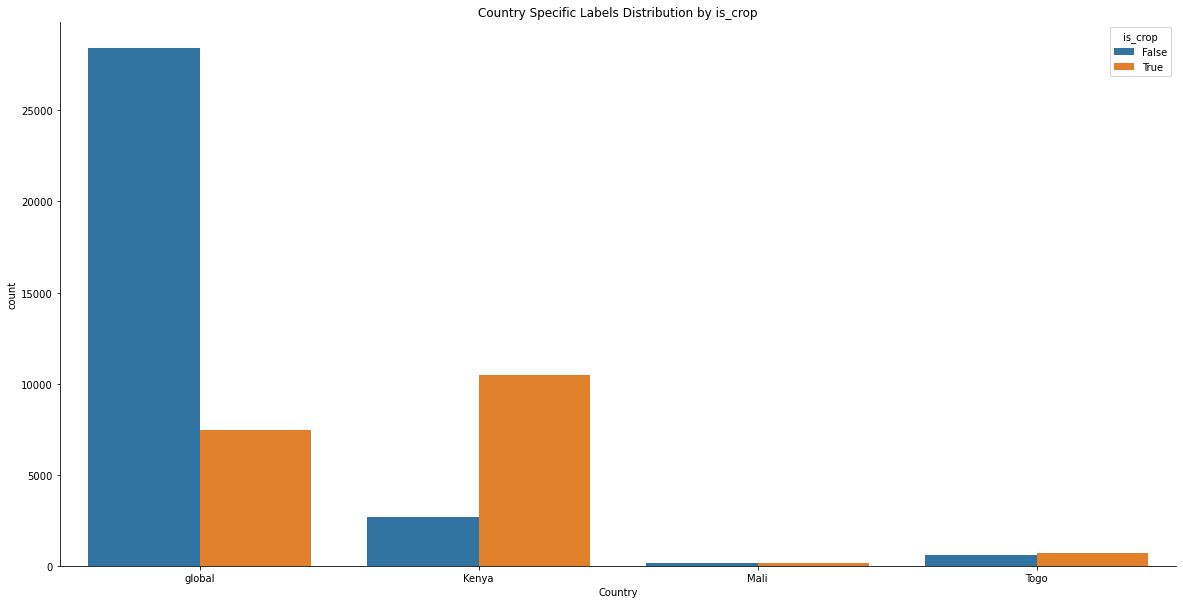

In [17]:
df["is_crop"] = df["crop_probability"] > 0.5 
plot_country_specific_labels(df, "is_crop")

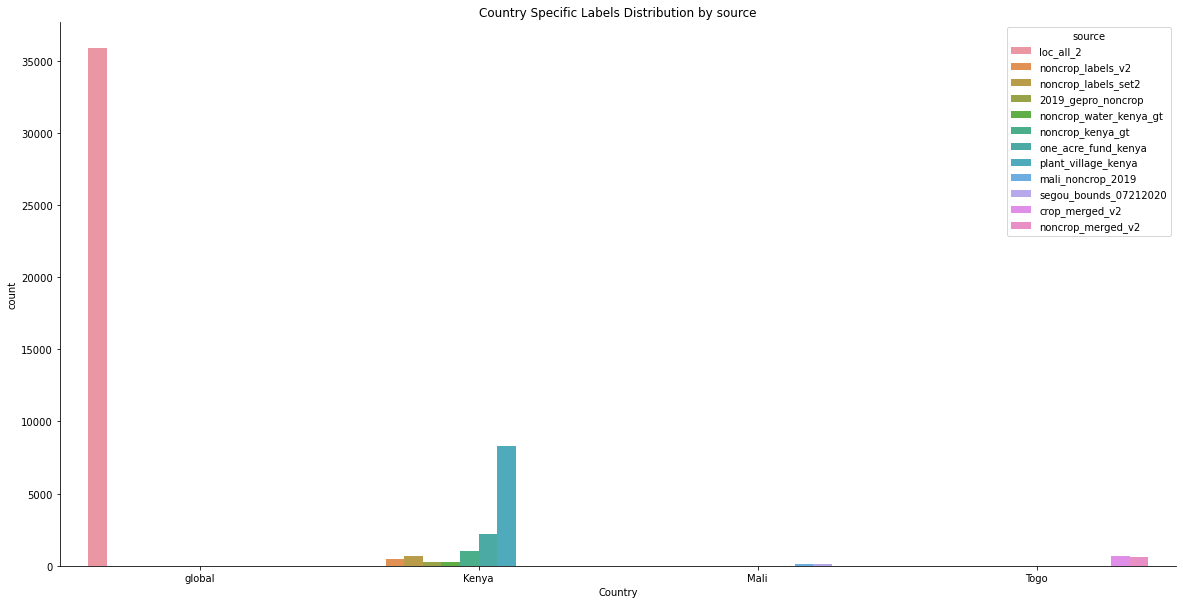

In [15]:
plot_country_specific_labels(df, "source")

In [24]:
df_non_global = df[df['Country'] != "global"]

def within_country(point: Point, country: str, pbar):
    pbar.update(1)
    return point.within(africa[africa["ADM0_NAME"] == country]["geometry"].iloc[0])


with tqdm(total=len(df_non_global)) as pbar:
    df_non_global["point_within_country"] = np.vectorize(within_country)(df_non_global["geometry"], df_non_global["Country"], pbar)

  0%|          | 0/14748 [00:00<?, ?it/s]

/opt/anaconda3/envs/landcover-mapping/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


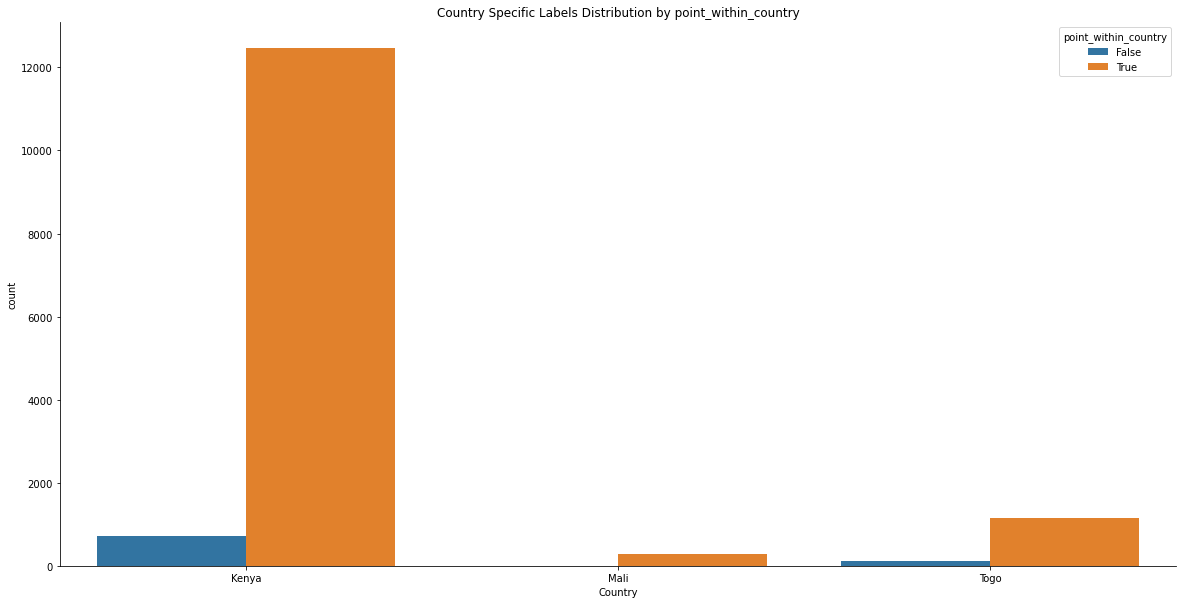

In [25]:
plot_country_specific_labels(df_non_global, "point_within_country")

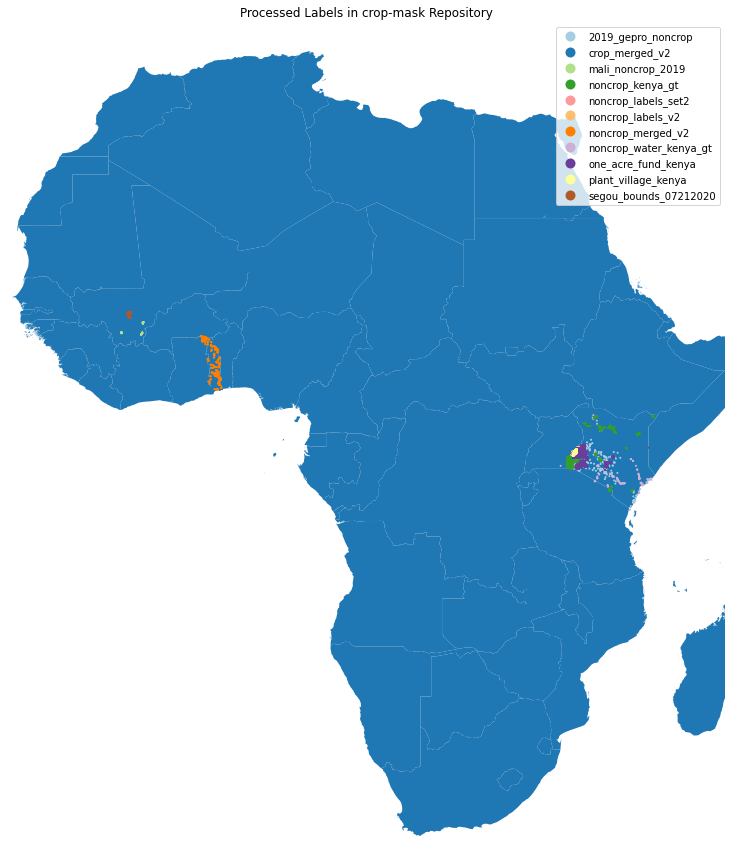

In [63]:
ax=test.africa.plot(figsize=(15,15))
ax.set_xlim(-18, 48)
ax.set_ylim(-35, 40)
ax.set_title("Label Locations")
ax.axis('off')
df_non_global.plot(
    ax=ax, 
    marker='o', 
    column='source', 
    categorical=True,
    markersize=1,
    cmap='Paired',
    legend=True);

# Checking Export Date Ranges

In [53]:
date_ranges = df[['start_date', 'end_date', 'source', 'Country']].drop_duplicates()

In [55]:
alt.Chart(date_ranges).mark_bar().encode(
    x='start_date',
    x2='end_date',
    y='source'
)

alt.Chart(...)

# Investigating Kenya PV Date Ranges

In [187]:
pv_kenya_dates = df[df['source'] == 'plant_village_kenya'][['planting_d', 'harvest_da']].drop_duplicates()
planting_dates = pd.to_datetime(pv_kenya_dates['planting_d'])
harvest_dates = pd.to_datetime(pv_kenya_dates['harvest_da'])
pv_kenya_dates['between_days'] = (harvest_dates - planting_dates).dt.days
pv_kenya_dates['valid'] = (0 < pv_kenya_dates['between_days']) & (pv_kenya_dates['between_days'] < 365)
pv_kenya_dates['planting_d'] = planting_dates.dt.strftime("%Y-%m-%d")
pv_kenya_dates['harvest_da'] = harvest_dates.dt.strftime("%Y-%m-%d")
pv_kenya_dates['range'] = pv_kenya_dates['planting_d'] + "_" + pv_kenya_dates['harvest_da']
pv_kenya_dates.head()

,planting_d,harvest_da,between_days,valid,range
4904,2018-11-15,2019-01-08,54,True,2018-11-15_2019-01-08
4905,2019-08-08,2020-01-04,149,True,2019-08-08_2020-01-04
4906,2019-07-17,2019-01-12,-186,False,2019-07-17_2019-01-12
4907,2019-07-26,2019-01-12,-195,False,2019-07-26_2019-01-12
4908,2019-01-08,2019-01-12,4,True,2019-01-08_2019-01-12


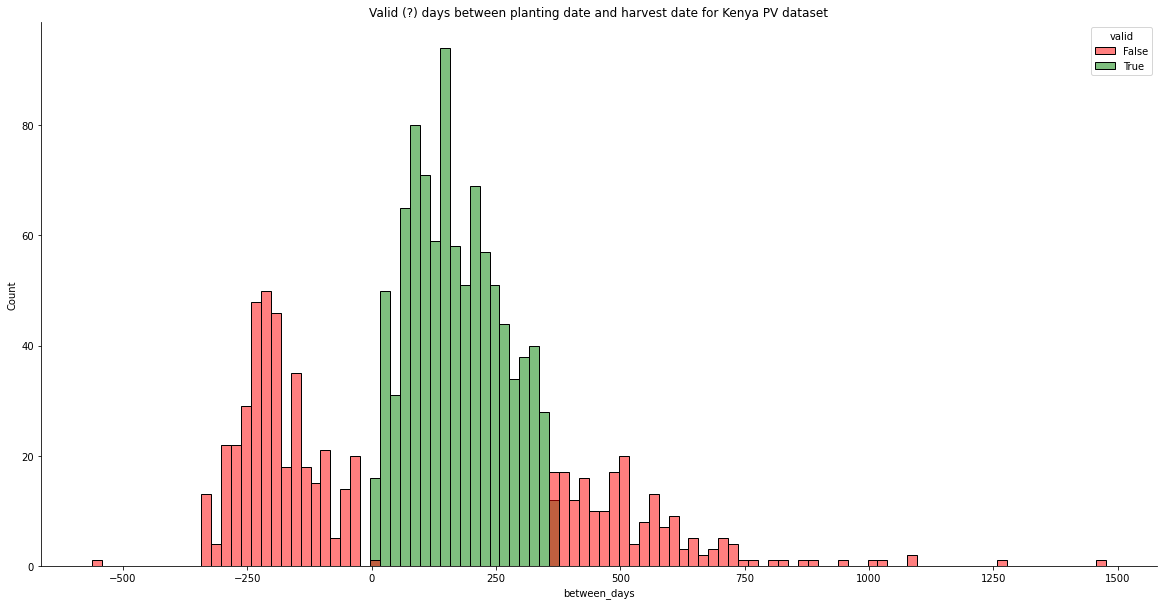

In [188]:
fig, ax = plt.subplots(figsize=(20,10))
sns.histplot(data=pv_kenya_dates, x='between_days', ax=ax, hue='valid', palette=["red", "green"], binwidth=20)
sns.despine()
ax.set_title("Valid (?) days between planting date and harvest date for Kenya PV dataset");